In [1]:
library(tidyverse,quietly = T)
library(caret,quietly = T)
library(AppliedPredictiveModeling,quietly = T)
library(Rtsne,quietly = T)
library(dplyr,quietly = T)
.libPaths("/root/R/x86_64-conda_cos6-linux-gnu-library/3.5")
library(cluster,quietly = T)
library(fpc,quietly = T)
library(caret,quietly = T)
require(randomForest,quietly = T)
library(ROCR,quietly = T)
library(reshape,quietly = T)
library(ggpubr,quietly = T)
library(gridExtra,quietly = T)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


Attaching package: ‘reshape’

The following object is masked from ‘package:dplyr’:

    rename

The following objects are masked from ‘package:tidyr’:

    expand, smiths


Attaching 

In [2]:
#head(cancer_cases)
mccs_ess <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ess_mccs_data.csv",stringsAsFactors=FALSE)
ess_siv_probs <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ESS_SIV_Probes.csv")


[1]  863 2210

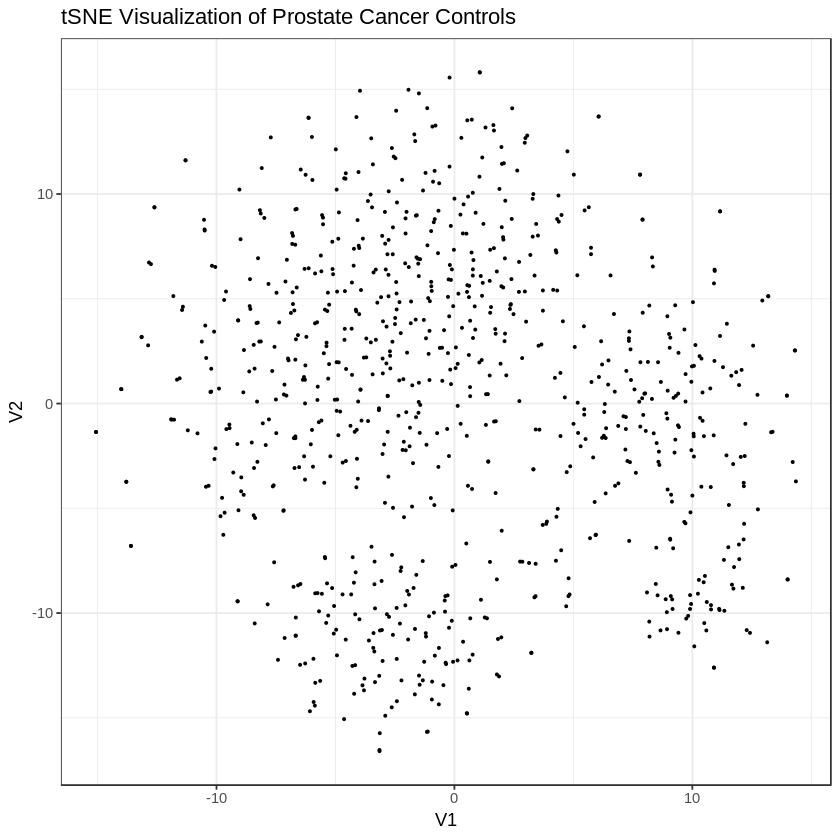

In [3]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='PC' & mccs_ess$CaseControl==1,]
cancer_control <- mccs_ess[mccs_ess$CancerCellType=="PC" & mccs_ess$CaseControl==0,]
cancer_cases_methy<- cancer_control[,ess_siv_probs$CG]#do the clustering based on controls

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("tSNE Visualization of Prostate Cancer Controls") +
  scale_colour_brewer(palette = "Set2")

DBSCAN clustering for 863 objects.
Parameters: eps = 1.6, minPts = 15
The clustering contains 5 cluster(s) and 256 noise points.

  0   1   2   3   4   5 
256 345 103 104  39  16 

Available fields: cluster, eps, minPts

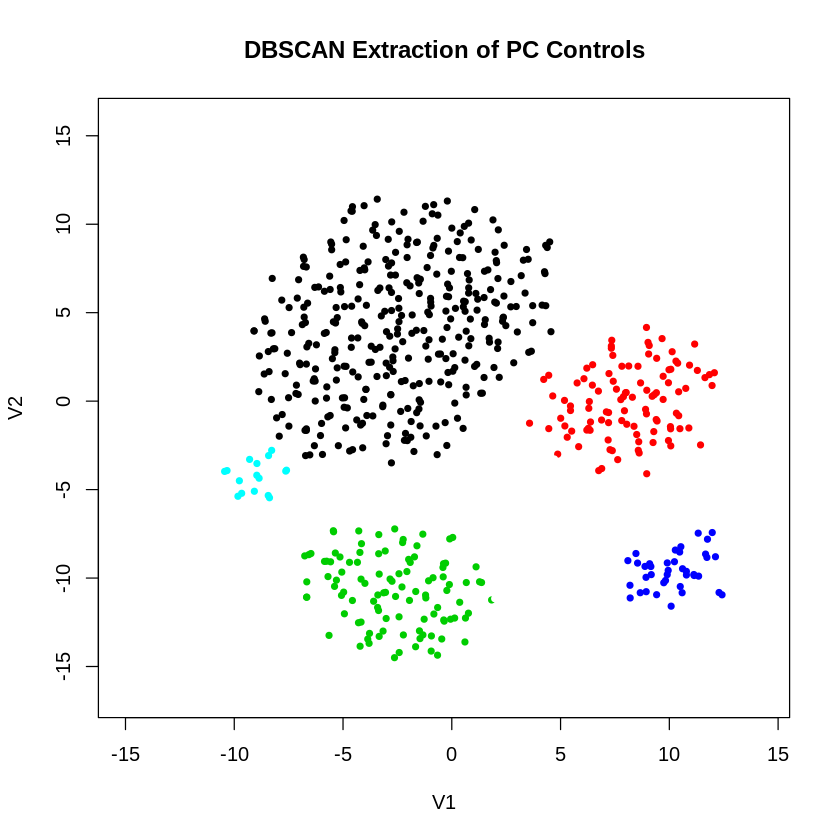

In [4]:
res <- dbscan::dbscan(d_tsne_3,eps = 1.6, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20,main="DBSCAN Extraction of PC Controls")
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res

In [5]:
d_tsne_3$cluster <- res$cluster
d_tsne_3$ID <- cancer_cases$ID
head(d_tsne_3) 

V1,V2,cluster,ID
13.972906,0.379845,0,PC_Pair_1
3.710935,-5.793976,0,PC_Pair_2
-2.693923,1.677066,1,PC_Pair_3
-2.053527,8.117369,1,PC_Pair_4
2.078947,11.471818,0,PC_Pair_5
-1.538436,6.915664,1,PC_Pair_6


In [6]:
tsne_model_cluster1 <- d_tsne_3[d_tsne_3$cluster==1,]
tsne_model_cluster2 <- d_tsne_3[d_tsne_3$cluster==2,]
tsne_model_cluster3 <- d_tsne_3[d_tsne_3$cluster==3,]


In [7]:
cancer_cases_controls_avg <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/averaged_accros_cluster.csv")

In [8]:
#cancer_cases_controls_avg$VTRNA2.1 <- NULL
#cancer_cases_controls_avg$DUSP22 <- NULL

In [9]:

cancer_cases_avg <- cancer_cases_controls_avg[cancer_cases_controls_avg$CancerCellType=="PC" & cancer_cases_controls_avg$CaseControl==1,]
cancer_controls_avg <- cancer_cases_controls_avg[cancer_cases_controls_avg$CancerCellType=="PC" & cancer_cases_controls_avg$CaseControl==0,]

In [10]:
cluster1_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster1$ID, ]
cluster2_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster2$ID, ]
cluster3_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster3$ID, ]

cluster1_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster1$ID,]
cluster2_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster2$ID,]
cluster3_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster3$ID,]

## Cases in Cluster 1  and matching controls

In [11]:
head(cluster1_cases)
head(cluster1_controls)


,Sample,CancerCellType,CaseControl,ID,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,⋯,VIPR2,VTRNA2.1,WDR27,WDR90,ZFP57,ZFYVE28,ZNF251,ZNF681,ZNF714,ZNF890P
4353,Sample_4353,PC,1,PC_Pair_3,1,Never,0.10082223,30.05003,0.1844862,0.12306696,⋯,1.6851114,0.1400600,0.6258309,-0.14372341,3.140365,2.954671,1.9219780,-3.259399,0.1057944,0.002889846
4355,Sample_4355,PC,1,PC_Pair_4,2,Former,0.06004972,27.90445,0.1091810,0.07194285,⋯,2.4120595,0.5453855,0.7982160,-0.92999168,3.155863,3.003048,0.5877212,-2.936598,0.8860706,0.326238155
4360,Sample_4360,PC,1,PC_Pair_6,4,Never,0.08055555,41.52421,0.1275946,0.09060549,⋯,-0.4110105,0.4845656,0.7149950,-0.74245508,1.666408,2.882332,1.9814976,-3.757477,0.7106879,0.289179001
4365,Sample_4365,PC,1,PC_Pair_9,1,Former,0.12074661,30.25284,0.1635966,0.06347843,⋯,1.6422992,0.6337266,0.5208607,-1.36734247,2.825907,3.398228,1.8370199,-3.473932,-0.7228802,0.065450257
4368,Sample_4368,PC,1,PC_Pair_10,2,Never,0.09044747,34.44719,0.1395447,0.01584869,⋯,0.9358887,-3.7414164,0.6163458,0.01486718,3.480020,3.492902,2.3198533,-3.703572,-0.2446626,0.330601986
4371,Sample_4371,PC,1,PC_Pair_12,2,Former,0.09640748,26.97505,0.2569712,0.11829751,⋯,2.7316328,0.7175397,0.8968330,0.29500106,3.185524,3.918877,0.4711776,-4.350934,-1.5875207,0.193001737


,Sample,CancerCellType,CaseControl,ID,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,⋯,VIPR2,VTRNA2.1,WDR27,WDR90,ZFP57,ZFYVE28,ZNF251,ZNF681,ZNF714,ZNF890P
4354,Sample_4354,PC,0,PC_Pair_3,4,Never,0.05037990,25.58598,0.1795933,0.08882190,⋯,3.5004475,0.5856435,0.4211313,-1.4144366,3.226914,3.245901,1.3239087,-3.986961,-1.7764825,-0.090754806
4356,Sample_4356,PC,0,PC_Pair_4,1,Never,0.11050807,30.67739,0.1801356,0.11107306,⋯,1.9433960,0.7128411,0.9361930,-0.1942653,3.068031,3.059673,0.5933022,-3.817015,0.7982271,0.686524890
4359,Sample_4359,PC,0,PC_Pair_6,3,Former,0.09378724,28.26854,0.1809759,0.17949657,⋯,0.8035994,0.7665506,1.0434265,0.1836838,2.949592,3.159290,1.6828115,-3.790084,-0.2694896,1.592955721
4366,Sample_4366,PC,0,PC_Pair_9,1,Never,0.05854633,23.73126,0.1239646,0.05605517,⋯,2.1737978,0.5669473,0.8824934,0.3770276,3.147779,3.332930,1.7516983,-3.529441,-2.3352008,0.002476586
4367,Sample_4367,PC,0,PC_Pair_10,2,Never,0.04802744,29.83255,0.1596357,0.07898714,⋯,2.7170133,0.7213955,0.9776894,-0.9262747,3.513851,3.642268,0.6561434,-2.864928,-1.3224880,0.733457572
4372,Sample_4372,PC,0,PC_Pair_12,2,Current,0.06848410,30.28917,0.1319471,0.09579111,⋯,2.0164186,0.5148479,1.1468841,-1.6178905,1.418268,3.423053,0.4593864,-3.763879,0.5892058,-1.024720132


In [12]:
cluster1_data <- rbind(cluster1_cases,cluster1_controls)
cluster1_data <- subset(cluster1_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster1_data$CaseControl <- as.factor(cluster1_data$CaseControl)


cluster2_data <- rbind(cluster2_cases,cluster2_controls)
cluster2_data <- subset(cluster2_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster2_data$CaseControl <- as.factor(cluster2_data$CaseControl)


cluster3_data <- rbind(cluster3_cases,cluster3_controls)
cluster3_data <- subset(cluster3_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster3_data$CaseControl <- as.factor(cluster3_data$CaseControl)

cluster1_data$cluster <- rep("C1",dim(cluster1_data)[1])
cluster2_data$cluster <- rep("C2",dim(cluster2_data)[1])
cluster3_data$cluster <- rep("C3",dim(cluster3_data)[1])

In [14]:
all_cluster_data <- rbind(cluster1_data,cluster2_data,cluster3_data)


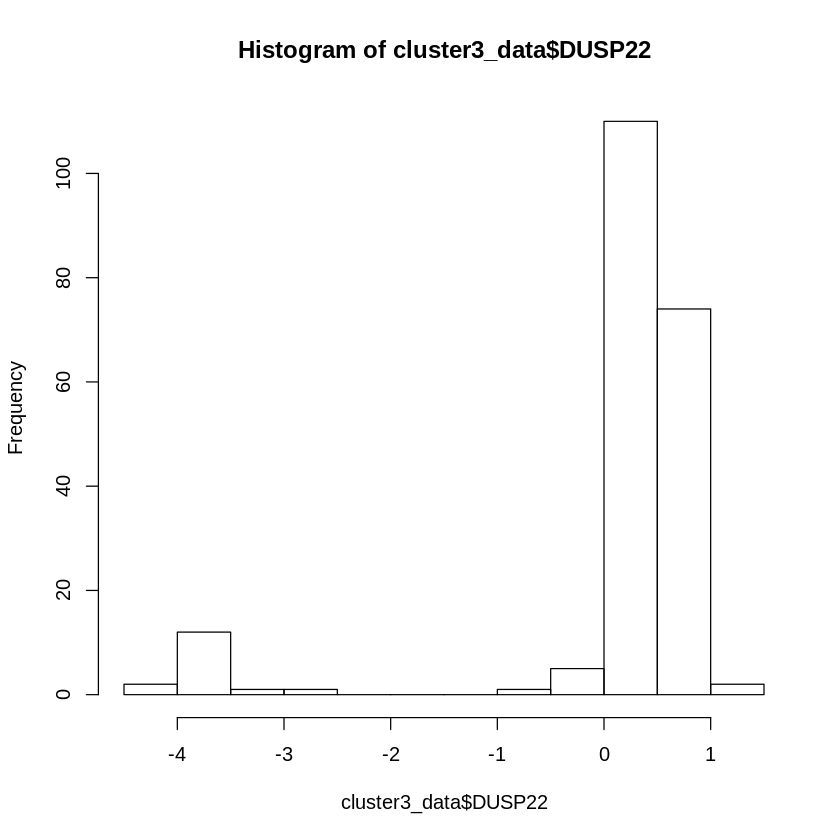

In [27]:
hist(cluster3_data$DUSP22)

# Machine Learning algorithms for Classiciation

# 1. Feature Selection using Partial Lease Squares (PLS)  Algorithm 

In [24]:
for (cluster_id in c("C1","C2","C3")){
    print(paste0("Running PLS  Feature selection algorithm for ",cluster_id))
    df <- all_cluster_data[all_cluster_data$cluster==cluster_id,]
    df$CaseControl <- as.factor(df$CaseContro)
    df$cluster <- NULL
    myfolds <- createMultiFolds(df$CaseControl, k = 5, times = 10)
    control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")

    # Train PLS model
    mod1 <- train(CaseControl ~ ., data = df,
     method = "pls",
     metric = "Accuracy",
     tuneLength = 20,
     trControl = control,
     preProc = c("zv","center","scale"))
    # Check CV profile
    plot(mod1)
    print(varImp(mod1))

}

[1] "Running PLS  Feature selection algorithm for C1"



Attaching package: ‘pls’

The following object is masked from ‘package:caret’:

    R2

The following object is masked from ‘package:stats’:

    loadings



pls variable importance

  only 20 most important variables shown (out of 145)

                  Overall
DUSP22             100.00
VTRNA2.1            87.21
TEKT4               28.49
PARD6G              26.39
PARD6G.PARD6G.AS1   26.39
OR2L13              24.40
CCKBR               23.40
PDE6B               22.31
LINC01115           21.41
UHMK1               20.30
GSDMD               20.21
LCLAT1              19.57
GFPT2               19.50
CYP4V2              18.73
LINC00606           18.37
LINC01044           18.02
TM9SF2              17.99
CRTC1               17.89
AGPAT4              17.86
DECR2               17.53
[1] "Running PLS  Feature selection algorithm for C2"
pls variable importance

  only 20 most important variables shown (out of 145)

             Overall
DUSP22        100.00
VTRNA2.1       33.94
RGS14          24.56
TOR4A          20.40
ZFP57          19.85
LY6G5C         19.80
MIR6763        18.89
HCG4B          17.71
DUSP5P1        17.63
KIF26A         17.43
CLDN3    

# Cluster 1 Case/Control comparison w.r.t DUSP22 and VTRNA2-1

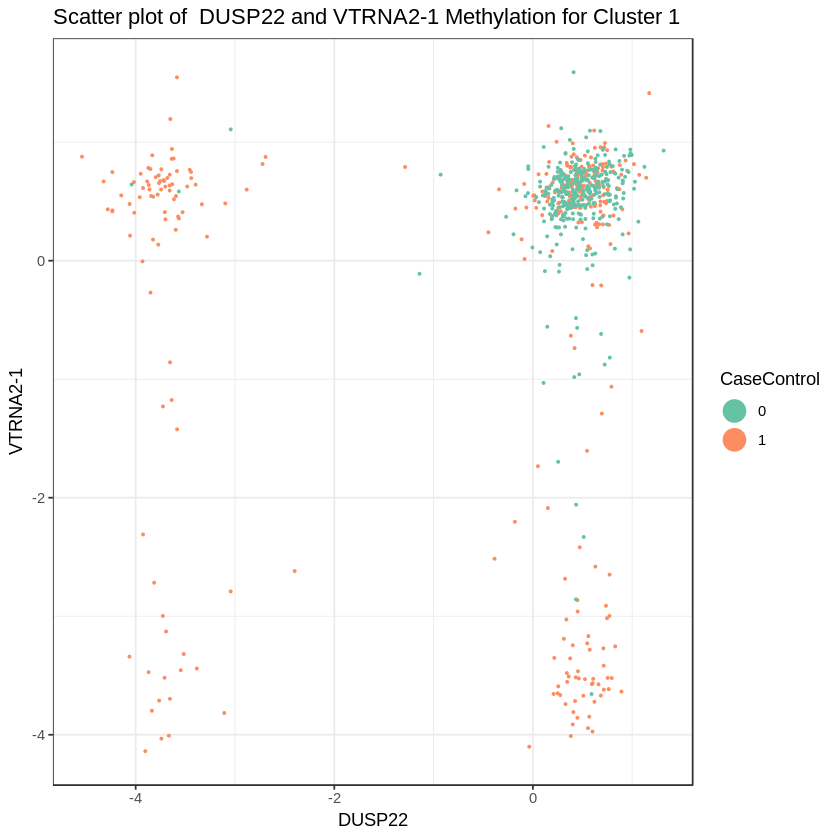

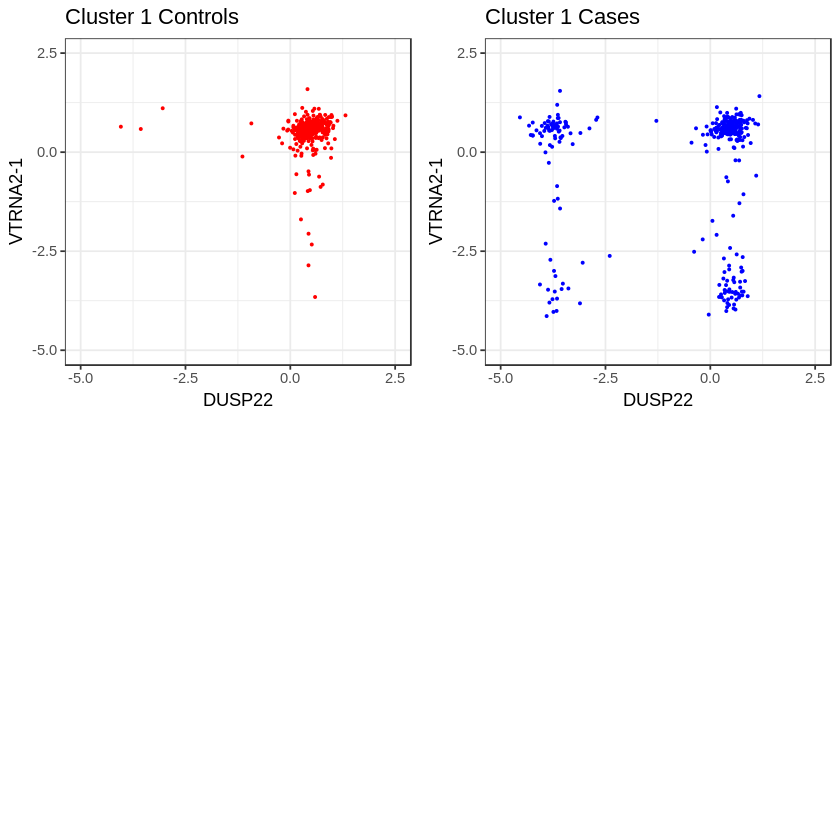

In [25]:
test_VT_DUSP <- cluster1_data[c("DUSP22","CaseControl","VTRNA2.1")]
g <- ggplot(test_VT_DUSP, aes(x=DUSP22, y=VTRNA2.1,colour = CaseControl)) +
geom_point(size=0.45) +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Scatter plot of  DUSP22 and VTRNA2-1 Methylation for Cluster 1") +
scale_colour_brewer(palette = "Set2")
print(g)

test_VT_DUSP <- cluster1_data[c("DUSP22","CaseControl","VTRNA2.1")]
test_VT_DUSP_1 <- test_VT_DUSP[test_VT_DUSP$CaseControl==1,]
test_VT_DUSP_0 <- test_VT_DUSP[test_VT_DUSP$CaseControl==0,]

g0_1 <- ggplot(test_VT_DUSP_0, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="red") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 1 Controls") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

g1_1 <- ggplot(test_VT_DUSP_1, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="blue") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 1 Cases") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

grid.arrange(g0_1, g1_1, ncol=2,nrow=2)

# Cluster 2 Case/Control comparison w.r.t DUSP22 and VTRNA2-1

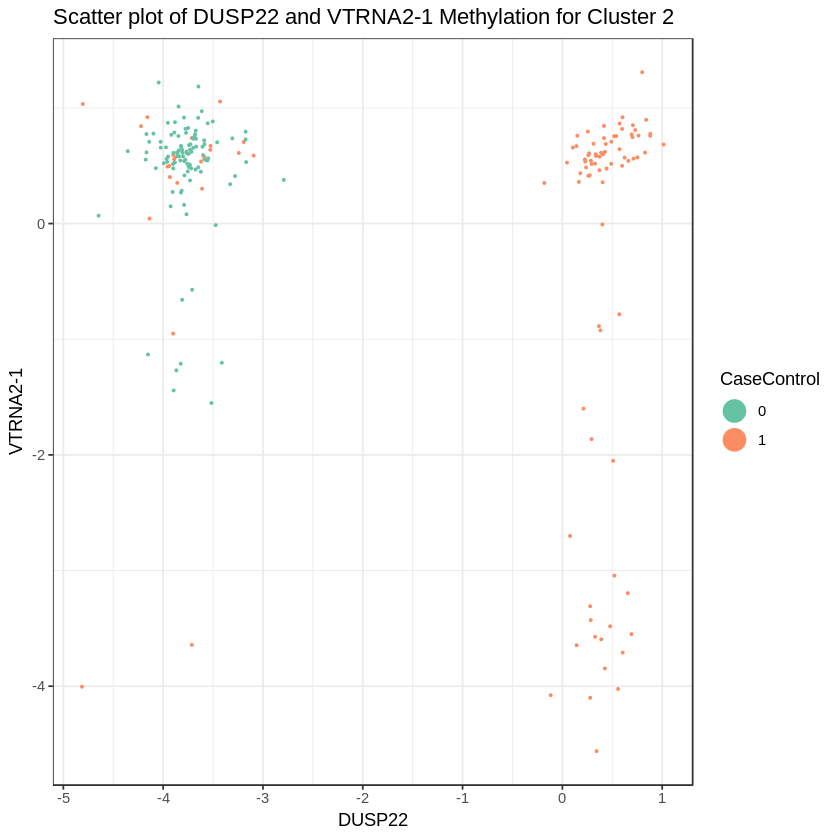

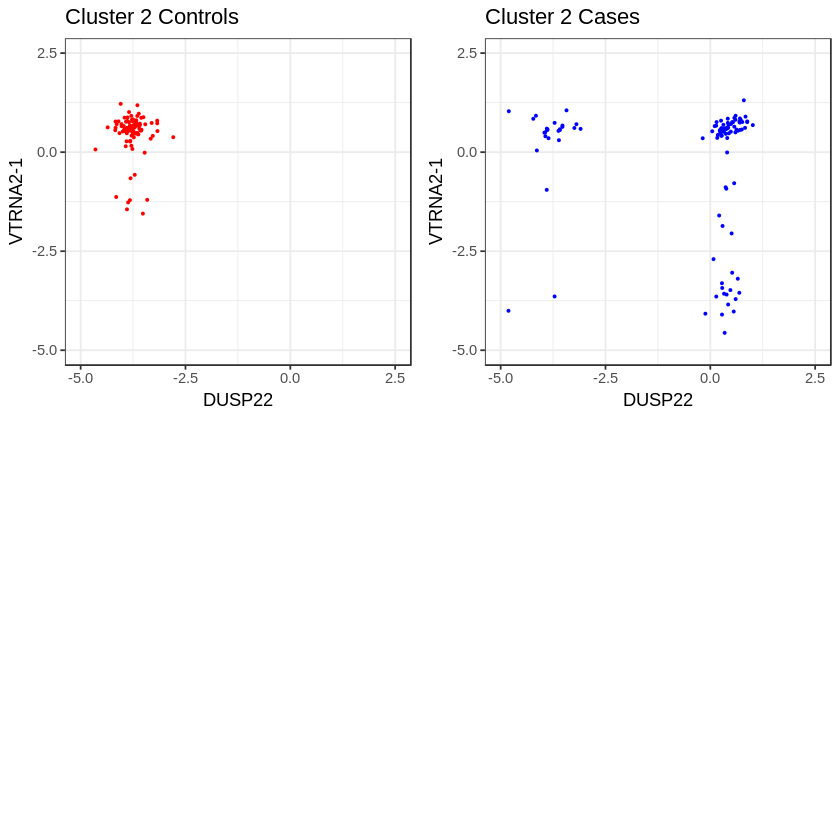

In [26]:
test_VT_DUSP <- cluster2_data[c("DUSP22","CaseControl","VTRNA2.1")]
g <- ggplot(test_VT_DUSP, aes(x=DUSP22, y=VTRNA2.1,colour = CaseControl)) +
geom_point(size=0.45) +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Scatter plot of DUSP22 and VTRNA2-1 Methylation for Cluster 2") +
scale_colour_brewer(palette = "Set2")
print(g)

test_VT_DUSP <- cluster2_data[c("DUSP22","CaseControl","VTRNA2.1")]
test_VT_DUSP_1 <- test_VT_DUSP[test_VT_DUSP$CaseControl==1,]
test_VT_DUSP_0 <- test_VT_DUSP[test_VT_DUSP$CaseControl==0,]

g0_2 <- ggplot(test_VT_DUSP_0, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="red") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 2 Controls") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

g1_2 <- ggplot(test_VT_DUSP_1, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="blue") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 2 Cases") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

grid.arrange(g0_2, g1_2, ncol=2,nrow=2)

# Cluster 3 Case/Control comparison w.r.t DUSP22 and VTRNA2-1

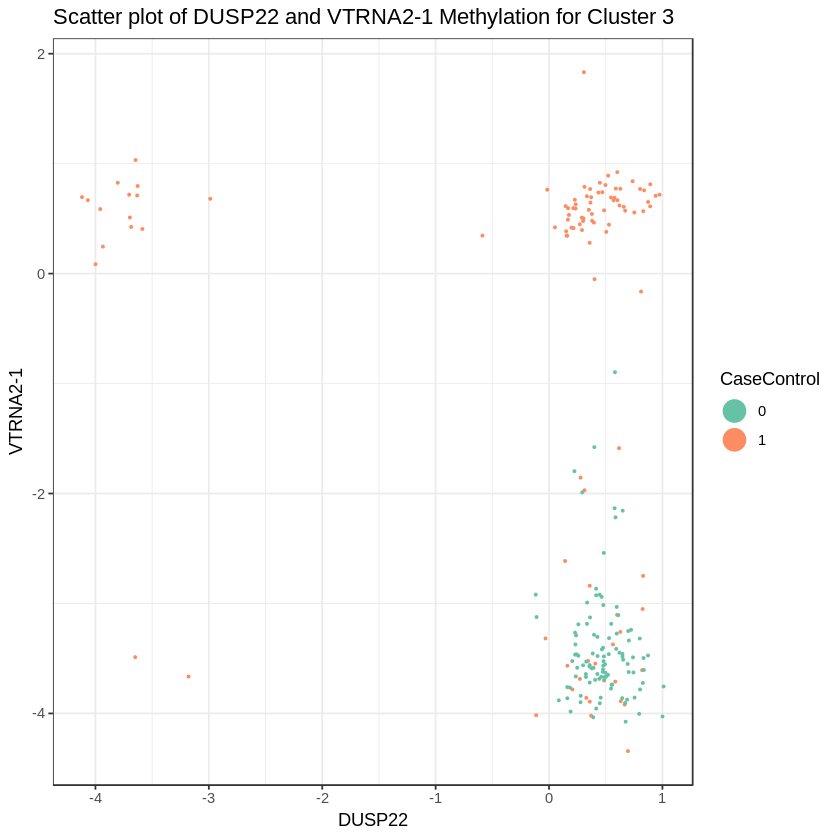

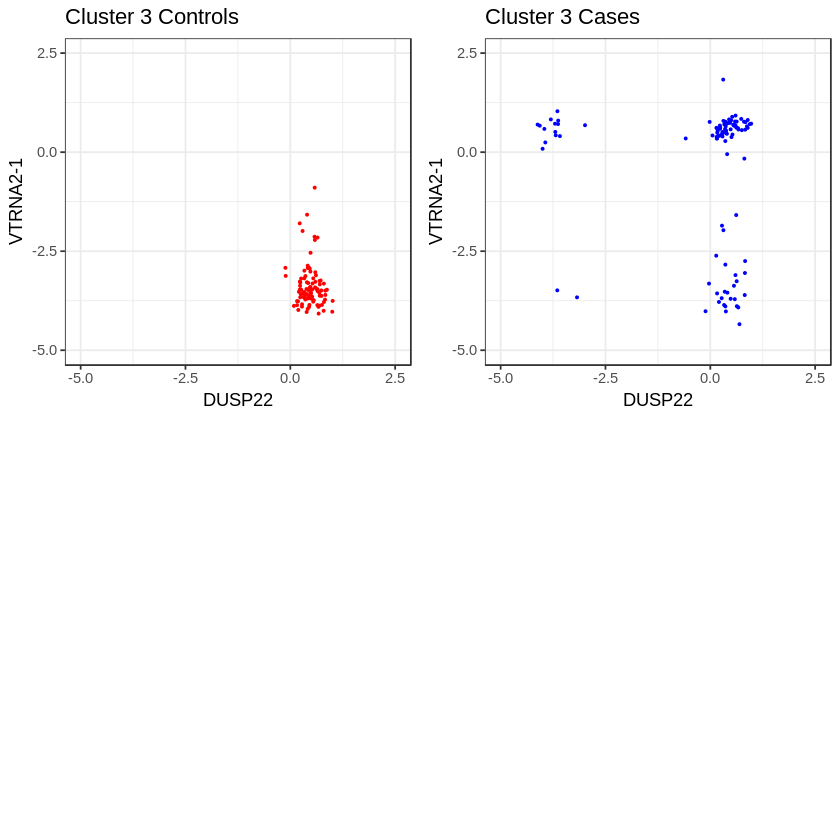

In [27]:
test_VT_DUSP <- cluster3_data[c("DUSP22","CaseControl","VTRNA2.1")]
g <- ggplot(test_VT_DUSP, aes(x=DUSP22, y=VTRNA2.1,colour = CaseControl)) +
geom_point(size=0.45) +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Scatter plot of DUSP22 and VTRNA2-1 Methylation for Cluster 3") +
scale_colour_brewer(palette = "Set2")
print(g)
test_VT_DUSP <- cluster3_data[c("DUSP22","CaseControl","VTRNA2.1")]
test_VT_DUSP_1 <- test_VT_DUSP[test_VT_DUSP$CaseControl==1,]
test_VT_DUSP_0 <- test_VT_DUSP[test_VT_DUSP$CaseControl==0,]

g0_3 <- ggplot(test_VT_DUSP_0, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="red") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 3 Controls") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

g1_3 <- ggplot(test_VT_DUSP_1, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="blue") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 3 Cases") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

grid.arrange(g0_3, g1_3, ncol=2,nrow=2)

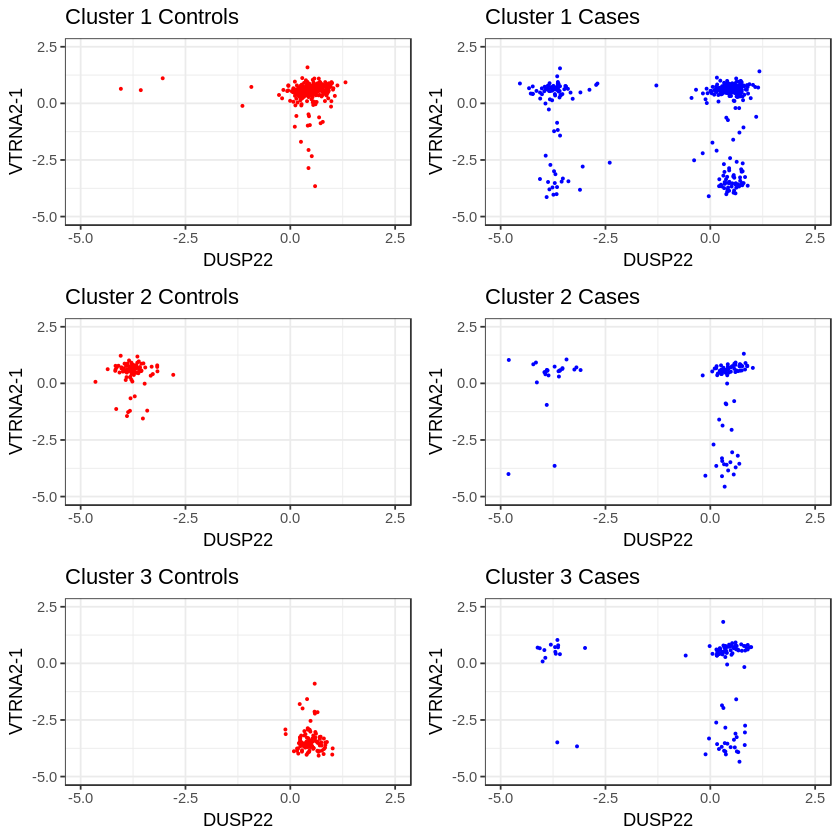

In [28]:
grid.arrange(g0_1,g1_1,g0_2,g1_2,g0_3,g1_3, ncol=2,nrow=3)